https://andersbrownworth.com/blockchain/blockchain

Blockchain Visualization Demo from Anders Brownworth

In [89]:
from google.colab import drive
drive.mount('/content/gdrive')
model_path = '/content/gdrive/MyDrive/Colab Notebooks/CSEE5590-AI4Cybersecurity/Lecture_11/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [90]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [91]:
# import torch
# from torchvision import datasets, transforms

# # Define a transform to normalize the data
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5,), (0.5,))])
# # Download and load the training data
# trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
# testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [92]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [93]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/5..  Training Loss: 0.342..  Test Loss: 0.164..  Test Accuracy: 0.949
Epoch: 2/5..  Training Loss: 0.171..  Test Loss: 0.164..  Test Accuracy: 0.948
Epoch: 3/5..  Training Loss: 0.138..  Test Loss: 0.137..  Test Accuracy: 0.958
Epoch: 4/5..  Training Loss: 0.118..  Test Loss: 0.132..  Test Accuracy: 0.959
Epoch: 5/5..  Training Loss: 0.108..  Test Loss: 0.112..  Test Accuracy: 0.968


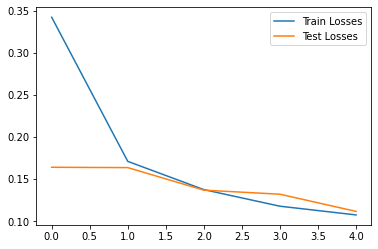

In [94]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Losses")
plt.plot(test_losses, label="Test Losses")
plt.legend()

In [95]:
torch.save(model.state_dict(), model_path + 'MNIST_model.pth')

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

In [96]:
model = Classifier()
criterion = nn.NLLLoss()


model.load_state_dict(torch.load(model_path + 'MNIST_model.pth'))
model.eval()

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [97]:
test_loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.967


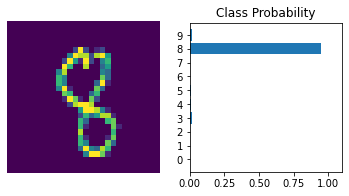

In [98]:
from random import randint
dataiter = iter(testloader)
images, labels = dataiter.next()

img = images[randint(0, len(images))]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps)

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Model Weight Attack

In [100]:
model.load_state_dict(torch.load(model_path + 'MNIST_model.pth'))
model_weights = model.state_dict()
model_layers = list(dict(model.named_modules()).keys())[1:]
from copy import deepcopy


## Trivial/Small Attack - 10 neuron change

In [101]:
'''
No-damage Attack 
'''
model_1 = Classifier()
tampered_model_weights = deepcopy(model_weights)
tampered_model_weights['fc3.weight'][0][0:10] = 0
model_1.load_state_dict(tampered_model_weights)


<All keys matched successfully>

In [102]:
'''
Small Attack
'''
model_1 = Classifier()
tampered_model_weights = deepcopy(model_weights)
tampered_model_weights['fc3.weight'] -= 0.07
model_1.load_state_dict(tampered_model_weights)


<All keys matched successfully>

In [103]:
accuracy = 0
with torch.no_grad():
    for images, labels in testloader:
        log_ps = model_1(images)   
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.846


## Medium Attack - add 0.2 to layer

In [104]:
'''
Medium Attack
'''
model_2 = Classifier()
tampered_model_weights = deepcopy(model_weights)
tampered_model_weights['fc3.weight'] += 0.2
model_2.load_state_dict(tampered_model_weights)


<All keys matched successfully>

In [105]:
accuracy = 0
with torch.no_grad():
    for images, labels in testloader:
        log_ps = model_2(images)   
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.752


## Large Attack - corrupt entire layer

In [106]:
'''
Large Attack - corrupt entire layer
'''
model_3 = Classifier()
tampered_model_weights = deepcopy(model_weights)
tampered_model_weights['fc3.weight'][0] = torch.rand(tampered_model_weights['fc3.weight'][0].shape)
model_3.load_state_dict(tampered_model_weights)


<All keys matched successfully>

In [107]:
accuracy = 0
with torch.no_grad():
    for images, labels in testloader:
        log_ps = model_3(images)   
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.780


In [108]:
# Test accuracy for each model with various scales of attack
with torch.no_grad():
    test_losses = [0, 0, 0, 0]
    accuracies = [0, 0, 0, 0]  
    for images, labels in testloader:
        log_ps = model(images)      
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracies[0] += torch.mean(equals.type(torch.FloatTensor))

        log_ps = model_1(images)     
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracies[1] += torch.mean(equals.type(torch.FloatTensor))

        log_ps = model_2(images)     
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracies[2] += torch.mean(equals.type(torch.FloatTensor))

        log_ps = model_3(images) 
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracies[3] += torch.mean(equals.type(torch.FloatTensor))
for accuracy in accuracies:
  print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.968
Test Accuracy: 0.847
Test Accuracy: 0.752
Test Accuracy: 0.780


# Blockchain


In [109]:
model.load_state_dict(torch.load(model_path + 'MNIST_model.pth'))
model_weights = model.state_dict()
model_layers = list(dict(model.named_modules()).keys())[1:]

In [110]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0329,  0.0086,  0.0243,  ...,  0.0497,  0.0563,  0.0528],
                      [-0.0129,  0.0104,  0.0365,  ...,  0.0194,  0.0207,  0.0246],
                      [ 0.0081,  0.0136, -0.0052,  ...,  0.0030,  0.0517,  0.0313],
                      ...,
                      [ 0.0393,  0.0300,  0.0377,  ...,  0.0255,  0.0073,  0.0581],
                      [ 0.0441,  0.0390,  0.0418,  ...,  0.0376, -0.0042,  0.0096],
                      [ 0.0226,  0.0080,  0.0011,  ..., -0.0116,  0.0461,  0.0215]])),
             ('fc1.bias',
              tensor([-5.0697e-02, -1.5882e-03, -4.5533e-02, -8.9822e-04, -7.9249e-02,
                       3.3151e-03, -3.6789e-02, -1.7230e-02, -5.2123e-02, -2.5209e-02,
                       8.5094e-03, -5.6987e-02, -2.2219e-02, -2.8807e-02, -1.7612e-02,
                       4.9885e-03, -1.4747e-03, -7.5809e-02,  1.5871e-02, -4.0564e-03,
                      -3.7250e-03, -4.6109e-02,  2.5242e-03,  4.

In [111]:
model_layers

['fc1', 'fc2', 'fc3', 'fc4']

In [112]:
model_weights

OrderedDict([('fc1.weight',
              tensor([[ 0.0329,  0.0086,  0.0243,  ...,  0.0497,  0.0563,  0.0528],
                      [-0.0129,  0.0104,  0.0365,  ...,  0.0194,  0.0207,  0.0246],
                      [ 0.0081,  0.0136, -0.0052,  ...,  0.0030,  0.0517,  0.0313],
                      ...,
                      [ 0.0393,  0.0300,  0.0377,  ...,  0.0255,  0.0073,  0.0581],
                      [ 0.0441,  0.0390,  0.0418,  ...,  0.0376, -0.0042,  0.0096],
                      [ 0.0226,  0.0080,  0.0011,  ..., -0.0116,  0.0461,  0.0215]])),
             ('fc1.bias',
              tensor([-5.0697e-02, -1.5882e-03, -4.5533e-02, -8.9822e-04, -7.9249e-02,
                       3.3151e-03, -3.6789e-02, -1.7230e-02, -5.2123e-02, -2.5209e-02,
                       8.5094e-03, -5.6987e-02, -2.2219e-02, -2.8807e-02, -1.7612e-02,
                       4.9885e-03, -1.4747e-03, -7.5809e-02,  1.5871e-02, -4.0564e-03,
                      -3.7250e-03, -4.6109e-02,  2.5242e-03,  4.

## Create a Blockchain

Important parameters: 

*   Nonce: to check for difficulty
*   Data: data to store in block (one or more transactions)
* Previous Hash: Hash of previous block
* Timestamp: time the block is created
* Block Number: order of block in chain



In [113]:
import datetime
import hashlib
class Block:
    blockNo = 0
    data = None
    next = None
    current_hash = None
    nonce = 0
    previous_hash = 0x0
    timestamp = datetime.datetime.now()

    def __init__(self, data):
        self.data = data

    def hash(self):
        h = hashlib.sha256()
        h.update(
          str(self.nonce).encode('utf-8') +
          str(self.data).encode('utf-8') +
          str(self.previous_hash).encode('utf-8') +
          str(self.timestamp).encode('utf-8') +
          str(self.blockNo).encode('utf-8')
        )
        return h.hexdigest()

    def __str__(self):
        return "\n--------------Block Hash: " + str(self.hash()) + "\nBlockNo: " + str(self.blockNo) + "\nBlock Data: " + str(self.data) + "\nNonce: " + str(self.nonce) + "\nPrevious Block Hash: " + str(self.previous_hash) +  "\n--------------" 


In [114]:
class Blockchain:
    difficulty = 1 # smaller = easier
    maxNonce = 2**32
    target = 2 ** (256-difficulty)
    def __init__(self):
        self.chain = []
        self.mine(Block("Genesis"))

    def add(self, block):
        self.chain.append(block)

    def mine(self, block):
        block.previous_hash = self.last_block.hash() if len(self.chain) > 0 else "00000000000000000000000000000000"
        block.blockNo = self.last_block.blockNo + 1 if len(self.chain) > 0 else 0
        for n in range(self.maxNonce):
            if int(block.hash(), 16) <= self.target:
              if block.hash().startswith('000'):
                print("Block {} - Qualified: {}".format(block.blockNo, block.hash()))
                self.add(block)
                break
            block.nonce += 1
    def modify_block(self, blockNo, injected_data): 
        target_block = self.chain[blockNo]
        target_block.data = injected_data
        return target_block.__str__()
    def validate_chain(self):
      for i, block in enumerate(self.chain):
        if block.blockNo > 0:
          print("\nPrevious_Hash: " + block.previous_hash)
          print('Hash of Previous Block: ' + self.chain[i-1].hash())
          if block.previous_hash != self.chain[i-1].hash():
            print('Block {} is tampered!'.format(block.blockNo - 1))
            return False
      print("Blockchain is correct!")
      return True

    @property
    def last_block(self):
        return self.chain[-1] if len(self.chain) > 0 else Block("Genesis")
    def __str__(self):
        for bl in self.chain:
          print(bl)
        return '==========================END OF CHAIN============================'

In [115]:
raw_data = []
for layer_name in model_layers:
  raw_data.append({
      "layer": layer_name,
      'weight' : model_weights[layer_name + '.weight'],
      'bias': model_weights[layer_name + '.bias'],

  })

In [116]:
blockchain = Blockchain()

Block 0 - Qualified: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4


In [117]:
for x in raw_data: 
  newBlock = Block(x)
  blockchain.mine(newBlock)

Block 1 - Qualified: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Block 2 - Qualified: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Block 3 - Qualified: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Block 4 - Qualified: 000c7d81680ba960bc28b54930ce571c511bca021e1bef7efc4d487951494832


In [118]:
print(blockchain)


--------------Block Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
BlockNo: 0
Block Data: Genesis
Nonce: 1176
Previous Block Hash: 00000000000000000000000000000000
--------------

--------------Block Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
BlockNo: 1
Block Data: {'layer': 'fc1', 'weight': tensor([[ 0.0329,  0.0086,  0.0243,  ...,  0.0497,  0.0563,  0.0528],
        [-0.0129,  0.0104,  0.0365,  ...,  0.0194,  0.0207,  0.0246],
        [ 0.0081,  0.0136, -0.0052,  ...,  0.0030,  0.0517,  0.0313],
        ...,
        [ 0.0393,  0.0300,  0.0377,  ...,  0.0255,  0.0073,  0.0581],
        [ 0.0441,  0.0390,  0.0418,  ...,  0.0376, -0.0042,  0.0096],
        [ 0.0226,  0.0080,  0.0011,  ..., -0.0116,  0.0461,  0.0215]]), 'bias': tensor([-5.0697e-02, -1.5882e-03, -4.5533e-02, -8.9822e-04, -7.9249e-02,
         3.3151e-03, -3.6789e-02, -1.7230e-02, -5.2123e-02, -2.5209e-02,
         8.5094e-03, -5.6987e-02, -2.2219e-02, -2.8807e-02, -1.76

In [119]:
'''
Validation one time before tampering
'''
blockchain.validate_chain()


Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Hash of Previous Block: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Blockchain is correct!


True

## Attack

In [120]:
'''
No-damage Attack
'''
from copy import deepcopy
targeted_block_id = 3 #layer 3 - fc3
original_data = deepcopy(blockchain.chain[targeted_block_id].data)

targeted_data = deepcopy(blockchain.chain[targeted_block_id].data)
print('Original weight: ' )
print(targeted_data['weight'])

targeted_data['weight'][0][0] = 0
print('\nModified weight: ')
print(targeted_data['weight'])



Original weight: 
tensor([[-0.0898,  0.0228, -0.0250,  ...,  0.0682, -0.1015, -0.0751],
        [ 0.0142, -0.0617, -0.0568,  ..., -0.0338, -0.0558,  0.0405],
        [-0.1508, -0.0901, -0.0380,  ...,  0.0528,  0.0925, -0.0676],
        ...,
        [ 0.0139,  0.0265, -0.1787,  ...,  0.0430,  0.0435, -0.0926],
        [-0.0654, -0.0217, -0.1451,  ...,  0.0332, -0.0209, -0.1631],
        [ 0.0609, -0.0105, -0.0566,  ...,  0.0403,  0.1513, -0.0428]])

Modified weight: 
tensor([[ 0.0000,  0.0228, -0.0250,  ...,  0.0682, -0.1015, -0.0751],
        [ 0.0142, -0.0617, -0.0568,  ..., -0.0338, -0.0558,  0.0405],
        [-0.1508, -0.0901, -0.0380,  ...,  0.0528,  0.0925, -0.0676],
        ...,
        [ 0.0139,  0.0265, -0.1787,  ...,  0.0430,  0.0435, -0.0926],
        [-0.0654, -0.0217, -0.1451,  ...,  0.0332, -0.0209, -0.1631],
        [ 0.0609, -0.0105, -0.0566,  ...,  0.0403,  0.1513, -0.0428]])


In [121]:
'''
Large Attack
'''
from copy import deepcopy
targeted_block_id = 3
original_data = deepcopy(blockchain.chain[targeted_block_id].data)

targeted_data = deepcopy(blockchain.chain[targeted_block_id].data)
print('Original weight: ' )
print(targeted_data['weight'])

targeted_data['weight'] = torch.rand(targeted_data['weight'].shape)
print('\nModified weight: ')
print(targeted_data['weight'])

Original weight: 
tensor([[-0.0898,  0.0228, -0.0250,  ...,  0.0682, -0.1015, -0.0751],
        [ 0.0142, -0.0617, -0.0568,  ..., -0.0338, -0.0558,  0.0405],
        [-0.1508, -0.0901, -0.0380,  ...,  0.0528,  0.0925, -0.0676],
        ...,
        [ 0.0139,  0.0265, -0.1787,  ...,  0.0430,  0.0435, -0.0926],
        [-0.0654, -0.0217, -0.1451,  ...,  0.0332, -0.0209, -0.1631],
        [ 0.0609, -0.0105, -0.0566,  ...,  0.0403,  0.1513, -0.0428]])

Modified weight: 
tensor([[0.3874, 0.3308, 0.9480,  ..., 0.5935, 0.3152, 0.7308],
        [0.2112, 0.8330, 0.6243,  ..., 0.8735, 0.0884, 0.6197],
        [0.6987, 0.5406, 0.6702,  ..., 0.9145, 0.0107, 0.0134],
        ...,
        [0.4107, 0.5313, 0.2373,  ..., 0.8513, 0.0068, 0.9602],
        [0.7672, 0.6073, 0.4661,  ..., 0.7781, 0.3702, 0.9556],
        [0.4003, 0.2200, 0.7532,  ..., 0.1002, 0.9396, 0.9293]])


In [122]:
print(blockchain.modify_block(targeted_block_id, targeted_data))


--------------Block Hash: 794c2363550d0409905ae9cb1872ca197883a6ca1ffe55ce86ea186a1e207f9e
BlockNo: 3
Block Data: {'layer': 'fc3', 'weight': tensor([[0.3874, 0.3308, 0.9480,  ..., 0.5935, 0.3152, 0.7308],
        [0.2112, 0.8330, 0.6243,  ..., 0.8735, 0.0884, 0.6197],
        [0.6987, 0.5406, 0.6702,  ..., 0.9145, 0.0107, 0.0134],
        ...,
        [0.4107, 0.5313, 0.2373,  ..., 0.8513, 0.0068, 0.9602],
        [0.7672, 0.6073, 0.4661,  ..., 0.7781, 0.3702, 0.9556],
        [0.4003, 0.2200, 0.7532,  ..., 0.1002, 0.9396, 0.9293]]), 'bias': tensor([-0.1711, -0.1505, -0.1412,  0.0111, -0.0597,  0.1476, -0.0710, -0.0209,
         0.1606,  0.2981,  0.1772, -0.2506, -0.0747, -0.2264, -0.2045, -0.3326,
        -0.1356, -0.0518, -0.1744, -0.1427, -0.0377,  0.1834,  0.2696,  0.4100,
        -0.2308, -0.2062, -0.0479,  0.0068, -0.1853,  0.1144, -0.1299,  0.1610,
        -0.0101,  0.0754,  0.0926, -0.0319,  0.1107,  0.1191, -0.2281, -0.1523,
        -0.2556, -0.1582, -0.0862, -0.0819, -0.0549

In [123]:
'''
Validate one time AFTER tampering
'''
blockchain.validate_chain()


Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Hash of Previous Block: 794c2363550d0409905ae9cb1872ca197883a6ca1ffe55ce86ea186a1e207f9e
Block 3 is tampered!


False

In [124]:
print(blockchain)


--------------Block Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
BlockNo: 0
Block Data: Genesis
Nonce: 1176
Previous Block Hash: 00000000000000000000000000000000
--------------

--------------Block Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
BlockNo: 1
Block Data: {'layer': 'fc1', 'weight': tensor([[ 0.0329,  0.0086,  0.0243,  ...,  0.0497,  0.0563,  0.0528],
        [-0.0129,  0.0104,  0.0365,  ...,  0.0194,  0.0207,  0.0246],
        [ 0.0081,  0.0136, -0.0052,  ...,  0.0030,  0.0517,  0.0313],
        ...,
        [ 0.0393,  0.0300,  0.0377,  ...,  0.0255,  0.0073,  0.0581],
        [ 0.0441,  0.0390,  0.0418,  ...,  0.0376, -0.0042,  0.0096],
        [ 0.0226,  0.0080,  0.0011,  ..., -0.0116,  0.0461,  0.0215]]), 'bias': tensor([-5.0697e-02, -1.5882e-03, -4.5533e-02, -8.9822e-04, -7.9249e-02,
         3.3151e-03, -3.6789e-02, -1.7230e-02, -5.2123e-02, -2.5209e-02,
         8.5094e-03, -5.6987e-02, -2.2219e-02, -2.8807e-02, -1.76

## Remine (Student's exercise)
So, block 3 was detected as invalid thanks to the `validate()` method. However, the attacker could simply re-mine the network from Block 3 to pass all the difficulty tests, which therefore will create a corrupted but totally valid blockchain. 

Let's remine the entire blockchain to the acceptable state.

In [125]:
new_blockchain = Blockchain()
'''
first, copy the correct blocks (healthy blocks before the corrupted one) from the corrupted blockchain
'''

newBlock = Block(blockchain.chain[1].data)
new_blockchain.mine(newBlock)
newBlock = Block(blockchain.chain[2].data)
new_blockchain.mine(newBlock)
print(new_blockchain)


Block 0 - Qualified: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Block 1 - Qualified: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Block 2 - Qualified: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

--------------Block Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
BlockNo: 0
Block Data: Genesis
Nonce: 1176
Previous Block Hash: 00000000000000000000000000000000
--------------

--------------Block Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
BlockNo: 1
Block Data: {'layer': 'fc1', 'weight': tensor([[ 0.0329,  0.0086,  0.0243,  ...,  0.0497,  0.0563,  0.0528],
        [-0.0129,  0.0104,  0.0365,  ...,  0.0194,  0.0207,  0.0246],
        [ 0.0081,  0.0136, -0.0052,  ...,  0.0030,  0.0517,  0.0313],
        ...,
        [ 0.0393,  0.0300,  0.0377,  ...,  0.0255,  0.0073,  0.0581],
        [ 0.0441,  0.0390,  0.0418,  ...,  0.0376, -0.0042,  0.0096],
        [ 0.0226,  0.0080,  0.001

In [126]:
'''
next, for the rest of the blockchain (remaining blocks), mine new blocks using the data from corrupted blockchain
'''
for remaining_block in blockchain.chain[targeted_block_id:]:
  newBlock = Block(remaining_block)
  new_blockchain.mine(newBlock)


Block 3 - Qualified: 000241271c00302230e59b3c2d101e500662c121f9007e7c75c284aacc7f4cde
Block 4 - Qualified: 0004c50a9b07a08fec571f561bdcbaa64a5397ac19cb6f255273362f9a3bb698


I corrupted block #3 so I need to remine the last 2 blocks, `3` and `4`. 
```
Block 3 - Qualified: 0008356eb442d99a61af3c2cb084fc8c10deccd570fbbd6ff8dc2c5101f0ed26
Block 4 - Qualified: 000c8572dea5751c62f11b8d385db058f9be5105170ee6fbe5d4ae88b21dfc33
```

In [127]:
'''
Validate after re-mining
'''
new_blockchain.validate_chain()


Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 000241271c00302230e59b3c2d101e500662c121f9007e7c75c284aacc7f4cde
Hash of Previous Block: 000241271c00302230e59b3c2d101e500662c121f9007e7c75c284aacc7f4cde
Blockchain is correct!


True

Comparison: 

Original Blockchain:
```

Previous_Hash: 00069904f6a0203da5e999d81fb2950033e0a2ca3b6f0c62dcf505ebc5a3ac5e
Hash of Previous Block: 00069904f6a0203da5e999d81fb2950033e0a2ca3b6f0c62dcf505ebc5a3ac5e

Previous_Hash: 00034f0cfbebb1eef3d1388b28d1f9bf636075695127fab2b0efab18cc82c454
Hash of Previous Block: 00034f0cfbebb1eef3d1388b28d1f9bf636075695127fab2b0efab18cc82c454

Previous_Hash: 000b2f693ec9803211acda48fb48722d12d7629afabb0bfba0344a565411938a
Hash of Previous Block: 000b2f693ec9803211acda48fb48722d12d7629afabb0bfba0344a565411938a

Previous_Hash: 000a37025f722d2e603687b47453811c1a3bca2d2a8c37819f5ea7df3fa9ab2d
Hash of Previous Block: 000a37025f722d2e603687b47453811c1a3bca2d2a8c37819f5ea7df3fa9ab2d
Blockchain is correct!
True

```

Corrupted Blockchain:

```
Previous_Hash: 00069904f6a0203da5e999d81fb2950033e0a2ca3b6f0c62dcf505ebc5a3ac5e
Hash of Previous Block: 00069904f6a0203da5e999d81fb2950033e0a2ca3b6f0c62dcf505ebc5a3ac5e

Previous_Hash: 00034f0cfbebb1eef3d1388b28d1f9bf636075695127fab2b0efab18cc82c454
Hash of Previous Block: 00034f0cfbebb1eef3d1388b28d1f9bf636075695127fab2b0efab18cc82c454

Previous_Hash: 000b2f693ec9803211acda48fb48722d12d7629afabb0bfba0344a565411938a
Hash of Previous Block: 000b2f693ec9803211acda48fb48722d12d7629afabb0bfba0344a565411938a

Previous_Hash: 000a37025f722d2e603687b47453811c1a3bca2d2a8c37819f5ea7df3fa9ab2d
Hash of Previous Block: e220ea395f49b3fb417160f973b504c2c8d05933e2f26567b1740ece779f3fe5
Block 3 is tampered!
False
```

Corrupted Blockchain (Re-hashed):

```
Previous_Hash: 00074f9f5c14b884c5faa8f5779cabfa0c32092be789b370d6c9439d15026ac0

Previous_Hash: 00069904f6a0203da5e999d81fb2950033e0a2ca3b6f0c62dcf505ebc5a3ac5e
Hash of Previous Block: 00069904f6a0203da5e999d81fb2950033e0a2ca3b6f0c62dcf505ebc5a3ac5e

Previous_Hash: 00034f0cfbebb1eef3d1388b28d1f9bf636075695127fab2b0efab18cc82c454
Hash of Previous Block: 00034f0cfbebb1eef3d1388b28d1f9bf636075695127fab2b0efab18cc82c454

Previous_Hash: 000b2f693ec9803211acda48fb48722d12d7629afabb0bfba0344a565411938a
Hash of Previous Block: 000b2f693ec9803211acda48fb48722d12d7629afabb0bfba0344a565411938a

Previous_Hash: 000b42a97c835056c1b40cf2c3f4026d1cff18077c7f1fbe9ce5b00ed8982139
Hash of Previous Block: 000b42a97c835056c1b40cf2c3f4026d1cff18077c7f1fbe9ce5b00ed8982139
Blockchain is correct!
True
```

In a decentralized network, consensus will prevent this from happening.

# Student Exercise: Implement P2P Simulation and Consensus with 3 or more peers.
Choose an attack for one of the peers.

Context: one client will have a corrupted blockchain (one or more blocks are defective but hashes pass all difficulties). 

Afterwards, the blockchain will be validated not only in terms of hashes, but also in terms of consistency throughout the network. If hashes do not check out across the peers, use consensus to recover the blockchain to the correct state.

Requirements: 
* Use 3 or more peers
* Use your own model
* Use the 51\% or 2/3 rule for consensus.

In [128]:
blockchain_1 = Blockchain()
blockchain_2 = Blockchain()
blockchain_3 = Blockchain()

for x in raw_data: 
  newBlock = Block(x)
  blockchain_1.mine(newBlock)
  blockchain_2.mine(newBlock)
  blockchain_3.mine(newBlock)

print("Peer 1 ")
print(blockchain_1)

print("Peer 2")
print(blockchain_2)

print("Peer 3")
print(blockchain_3)

Block 0 - Qualified: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Block 0 - Qualified: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Block 0 - Qualified: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Block 1 - Qualified: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Block 1 - Qualified: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Block 1 - Qualified: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Block 2 - Qualified: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Block 2 - Qualified: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Block 2 - Qualified: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Block 3 - Qualified: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Block 3 - Qualified: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Block 3 - Qualified: 0009d8e76e342a61f09fd80be502c28ac

In [129]:
blockchain_1.validate_chain()
blockchain_2.validate_chain()
blockchain_3.validate_chain()



Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Hash of Previous Block: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Blockchain is correct!

Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b

True

In [130]:
# Attack on blockchain_1
'''
Large Attack
'''
from copy import deepcopy
targeted_block_id = 3
original_data = deepcopy(blockchain_1.chain[targeted_block_id].data)

targeted_data = deepcopy(blockchain_1.chain[targeted_block_id].data)
print('Original weight: ' )
print(targeted_data['weight'])

targeted_data['weight'] = torch.rand(targeted_data['weight'].shape)
print('\nModified weight: ')
print(targeted_data['weight'])


print(blockchain_1.modify_block(targeted_block_id, targeted_data))

Original weight: 
tensor([[-0.0898,  0.0228, -0.0250,  ...,  0.0682, -0.1015, -0.0751],
        [ 0.0142, -0.0617, -0.0568,  ..., -0.0338, -0.0558,  0.0405],
        [-0.1508, -0.0901, -0.0380,  ...,  0.0528,  0.0925, -0.0676],
        ...,
        [ 0.0139,  0.0265, -0.1787,  ...,  0.0430,  0.0435, -0.0926],
        [-0.0654, -0.0217, -0.1451,  ...,  0.0332, -0.0209, -0.1631],
        [ 0.0609, -0.0105, -0.0566,  ...,  0.0403,  0.1513, -0.0428]])

Modified weight: 
tensor([[0.4656, 0.2029, 0.5147,  ..., 0.1370, 0.2737, 0.7825],
        [0.2189, 0.9766, 0.2079,  ..., 0.5263, 0.8683, 0.7288],
        [0.8510, 0.2296, 0.0274,  ..., 0.6003, 0.1559, 0.6018],
        ...,
        [0.7982, 0.1002, 0.1200,  ..., 0.7223, 0.6316, 0.7632],
        [0.7956, 0.2127, 0.4723,  ..., 0.2145, 0.3333, 0.5660],
        [0.6309, 0.2385, 0.8584,  ..., 0.1319, 0.6289, 0.8281]])

--------------Block Hash: 02b614196f85f7c13ec57dae3f6b7bcca149c48472336d01f37bb8a3c8904bb1
BlockNo: 3
Block Data: {'layer': 'fc3',

In [131]:
'''
Validate one time AFTER tampering
'''
blockchain_1.validate_chain()


Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Hash of Previous Block: 02b614196f85f7c13ec57dae3f6b7bcca149c48472336d01f37bb8a3c8904bb1
Block 3 is tampered!


False

In [132]:
# Remining

new_blockchain_1 = Blockchain()
'''
first, copy the correct blocks (healthy blocks before the corrupted one) from the corrupted blockchain
'''

newBlock = Block(blockchain_1.chain[1].data)
new_blockchain_1.mine(newBlock)
newBlock = Block(blockchain_1.chain[2].data)
new_blockchain_1.mine(newBlock)
print(new_blockchain_1)

Block 0 - Qualified: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Block 1 - Qualified: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Block 2 - Qualified: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

--------------Block Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
BlockNo: 0
Block Data: Genesis
Nonce: 1176
Previous Block Hash: 00000000000000000000000000000000
--------------

--------------Block Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
BlockNo: 1
Block Data: {'layer': 'fc1', 'weight': tensor([[ 0.0329,  0.0086,  0.0243,  ...,  0.0497,  0.0563,  0.0528],
        [-0.0129,  0.0104,  0.0365,  ...,  0.0194,  0.0207,  0.0246],
        [ 0.0081,  0.0136, -0.0052,  ...,  0.0030,  0.0517,  0.0313],
        ...,
        [ 0.0393,  0.0300,  0.0377,  ...,  0.0255,  0.0073,  0.0581],
        [ 0.0441,  0.0390,  0.0418,  ...,  0.0376, -0.0042,  0.0096],
        [ 0.0226,  0.0080,  0.001

In [133]:
'''
next, for the rest of the blockchain (remaining blocks), mine new blocks using the data from corrupted blockchain
'''
for remaining_block in blockchain_1.chain[targeted_block_id:]:
  newBlock = Block(remaining_block)
  new_blockchain_1.mine(newBlock)

Block 3 - Qualified: 0009a579070bd5a15bf7dd5cadc6743245fd9c63660ddd5eb3815ad770cc492e
Block 4 - Qualified: 0007cd36257959de4054e276d9fe23c365a69a8e0686c66774ac5338f6b1ab76


In [134]:

polling = 0
decision = new_blockchain_1.validate_chain()
if decision:
  polling = polling + 1


Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009a579070bd5a15bf7dd5cadc6743245fd9c63660ddd5eb3815ad770cc492e
Hash of Previous Block: 0009a579070bd5a15bf7dd5cadc6743245fd9c63660ddd5eb3815ad770cc492e
Blockchain is correct!


In [135]:
blockchain_copy_2 = blockchain_2 

blockchain_copy_2.modify_block(targeted_block_id, targeted_data)

decision_block2 = blockchain_copy_2.validate_chain()

if  blockchain_copy_2.validate_chain():
  polling = polling + 1

print("res ", decision_block2)


Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Hash of Previous Block: 02b614196f85f7c13ec57dae3f6b7bcca149c48472336d01f37bb8a3c8904bb1
Block 3 is tampered!

Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68

In [136]:
blockchain_copy_3 = blockchain_3 
blockchain_copy_3.modify_block(targeted_block_id, targeted_data)

decision_block3 = blockchain_copy_3.validate_chain()
if  blockchain_copy_3.validate_chain():
  polling = polling + 1

print("res ", decision_block3)


Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Hash of Previous Block: 02b614196f85f7c13ec57dae3f6b7bcca149c48472336d01f37bb8a3c8904bb1
Block 3 is tampered!

Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68

In [138]:
numPeers = 3
consensus_factor = polling/numPeers

print(consensus_factor)

0.3333333333333333


In [139]:
blockchain_copy_1 = blockchain_1
if consensus_factor < 0.51:
  print("Correct defective block")
  blockchain_copy_3.modify_block(targeted_block_id, original_data)
  blockchain_copy_2.modify_block(targeted_block_id, original_data)
  blockchain_copy_1.modify_block(targeted_block_id, original_data)
  blockchain_copy_3.validate_chain()
  blockchain_copy_2.validate_chain()
  blockchain_copy_1.validate_chain()
else:
  print("All is well!")  



Correct defective block

Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326

Previous_Hash: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb
Hash of Previous Block: 0001d8da5c0913b23b5263cb3d4d7b06c70606554d6030a9ba32f286a69f68bb

Previous_Hash: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Hash of Previous Block: 0009d8e76e342a61f09fd80be502c28ac358a8f8c04a275534665ba2a9b3558c
Blockchain is correct!

Previous_Hash: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4
Hash of Previous Block: 00008617b0d4b8e5e1638e7ee688a5faf1e56ab43cca4ebb24d0f1f0917029d4

Previous_Hash: 0009d7f082909aa7b0f04b68a7e65c85f5e271f08398403fd0301ae413e08326
Hash of Previous Block